In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from math import pi

PI = tf.constant(pi, dtype=tf.float32)

In [2]:
NUM_EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = 100
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096

ACTIVATION_ELU = tf.keras.activations.elu
ACTIVATION_SOFTPLUS = tf.keras.activations.softplus
ACTIVATION = ACTIVATION_ELU

In [3]:
import tensorflow_probability as tfp
norm = tfp.distributions.Normal(loc=0., scale=1.)
norm.pdf = norm.prob

def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / tf.math.sqrt(T)
    return  vol * tf.math.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / tf.math.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / tf.math.sqrt(T)
    return tf.math.sqrt(T) * norm.pdf(d)


# generates a random correlation matrix
def genCorrel(n):
    randoms = tf.random.uniform(minval=-1., maxval=1., shape=(2*n, n))
    cov = tf.transpose(randoms) @ randoms
    invvols = tf.linalg.diag(1. / tf.math.sqrt(tf.linalg.diag_part(cov)))
    return invvols @ cov @ invvols

genCorrel(3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.0000001 , 0.61064714, 0.62302864],
       [0.61064714, 1.        , 0.23504055],
       [0.6230287 , 0.23504055, 0.99999994]], dtype=float32)>

(10000, 1)
(10000, 1)
(10000, 1)


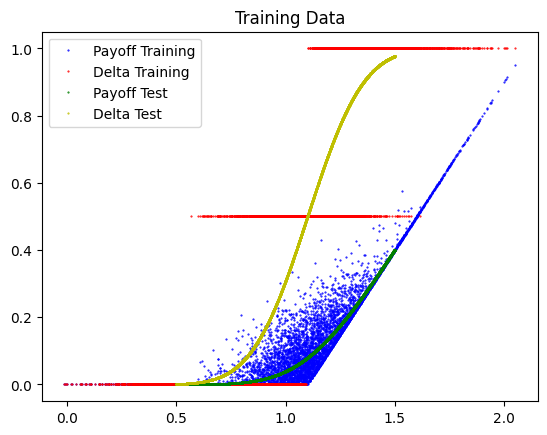

In [4]:
class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1.0, 
                 T2=2.0, 
                 K=1.10,
                 volMult=1.5):
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        tf.random.set_seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = tf.ones(self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = tf.random.uniform(minval=1., maxval=10., shape=(self.n,))

        # self.a /= np.sum(self.a)
        self.a /= tf.reduce_sum(self.a)

        # random vols
        # vols = np.random.uniform(low=5., high = 50., size = self.n)
        vols = tf.random.uniform(minval=5., maxval=50., shape=(self.n,))

        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        # avols = (self.a * vols).reshape((-1,1))
        avols = tf.reshape(self.a * vols, (-1,1))

        v = tf.sqrt(tf.transpose(avols) @ self.corr @ avols)
        v = tf.squeeze(v, axis=1)

        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = tf.linalg.diag(self.vols)
        # self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.cov = diagv @ self.corr @ diagv
        # self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        self.chol = tf.linalg.cholesky(self.cov) * tf.math.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * tf.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = tf.random.normal(shape=[2, m, self.n])
        inc0 = normals[0, :, :] @ tf.transpose(self.chol0)
        inc1 = normals[1, :, :] @ tf.transpose(self.chol)
    
        S1 = self.S0 + inc0
        
        S2 = S1 + inc1
        # bkt2 = np.dot(S2, self.a)
        bkt2 = tf.tensordot(S2, self.a, axes=1)

        pay = tf.math.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = tf.tensordot(S2a, self.a, axes=1)
            paya = tf.math.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 = tf.reshape(tf.where(bkt2 > self.K, 1.0, 0.0), (-1, 1)) * tf.reshape(self.a, (1, -1))
            Z2 =  tf.reshape(tf.where(bkt2a > self.K, 1.0, 0.0), (-1,1)) * tf.reshape(self.a, (1, -1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z = tf.reshape(tf.where(bkt2 > self.K, 1.0, 0.0), (-1, 1)) * tf.reshape(self.a, (1, -1))
            
        return X, tf.reshape(Y, (-1,1)), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        tf.random.set_seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * tf.math.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = tf.random.uniform(minval=adj_lower, maxval=adj_upper, shape=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = tf.reshape(tf.tensordot(spots, self.a, axes=1), (-1, 1))
        prices = tf.reshape(bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1),(-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ tf.reshape(self.a, (1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas    

bach = Bachelier(1)
X, Y, Z = bach.trainingSet(10000, anti=True)
spots, baskets, prices, deltas, vegas = bach.testSet(num=10000)


# plot training set:

def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, dydx_test):
    plt.title("Training Data")
    plt.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    plt.plot(x_train, dydx_train, 'r.', label='Delta Training', markersize=1)
    plt.plot(x_test, y_test, 'g.', label='Payoff Test', markersize=1)
    plt.plot(x_test, dydx_test, 'y.', label='Delta Test', markersize=1)
    plt.legend()
    plt.show()


print(X.shape)
print(Y.shape)
print(Z.shape)
plot_training_data(X[:,0], Y[:,0], Z[:,0], spots[:, 0], prices[:,0], deltas[:,0])


(1000, 1)
(1000, 1)
(1000, 1)


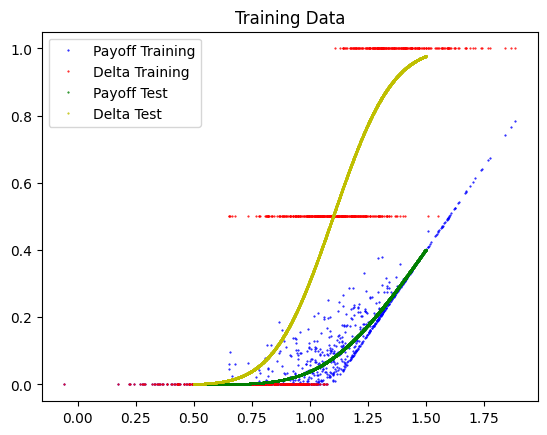

In [5]:
class BachelierGrads:
    
    def __init__(self, 
                 n,
                 T1=1.0, 
                 T2=2.0, 
                 K=1.10,
                 volMult=1.5):
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    @tf.function
    def trainingSet(self, m, seed=None, anti=True, bktVol=0.2):
    
        tf.random.set_seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = tf.ones(self.n)

        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = tf.random.uniform(minval=1., maxval=10., shape=(self.n,))
        self.a /= tf.reduce_sum(self.a)

        self.bktVol = bktVol

        # random vols
        vols = tf.random.uniform(minval=5., maxval=50., shape=(self.n,))

        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = tf.reshape(self.a * vols, (-1,1))

        v = tf.sqrt(tf.transpose(avols) @ self.corr @ avols)
        v = tf.squeeze(v, axis=1)

        self.vols = vols * bktVol / v

        # Choleski etc. for simulation
        diagv = tf.linalg.diag(self.vols)
        self.cov = diagv @ self.corr @ diagv
        self.chol = tf.linalg.cholesky(self.cov) * tf.math.sqrt(self.T2 - self.T1)
        self.chol0 = self.chol * self.volMult * tf.sqrt(self.T1 / (self.T2 - self.T1))

        # X = tf.Variable(tf.zeros_like(self.S0), name='X')
        normals = tf.random.normal(shape=[2, m, self.n])

        inc0 = normals[0, :, :] @ tf.transpose(self.chol0)
        inc1 = normals[1, :, :] @ tf.transpose(self.chol)
    
        S1 = self.S0 + inc0
        S2 = S1 + inc1
        bkt2 = tf.tensordot(S2, self.a, axes=1)

        pay = tf.math.maximum(0.0, bkt2 - self.K)

        if anti: 

            S2a = S1 - inc1
            bkt2a = tf.tensordot(S2a, self.a, axes=1)
            paya = tf.math.maximum(0.0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
        else:
            X = S1
            Y = pay
        
        # dYdX = tf.zeros_like(X)
        # dYdX = tf.stack(tf.gradients(Y, X)[0])
        # print(dYdX.shape)
        # dYdX = tf.stack(tf.gradients(Y, X)[0])
        # print(dYdX.shape)
# hessian_op = t f . s t a c k ( [ t f . g r a d i e n t s ( ys=df_op [ i ] , xs=t f_ v a r s ) [ 0 ] f o r i i n r an ge ( 0 ,
# df_op . shape [ 0 ] ) ] )

        # ddYddX = tf.gradients(dYdX, X)[0]
        # ddYddX = tf.stack([tf.gradients(dYdX[i], X)[0] for i in range(0, dYdX.shape[0])])
        
        # print(Y.shape)
        Y = tf.reshape(Y, (-1,1))
        # print(X.shape)
        # ddYddX = tf.hessians(Y, X)
        # ddYddX = tf.hessians(Y, X)

        dYdX = tf.gradients(Y, X)[0]
        # ddYddX = tf.stack([tf.gradients(dYdX[i], X)[0] for i in range(0, dYdX.shape[0])])

        return X, tf.reshape(Y, (-1,1)), dYdX

    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
    
        tf.random.set_seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * tf.math.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = tf.random.uniform(minval=adj_lower, maxval=adj_upper, shape=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = tf.reshape(tf.tensordot(spots, self.a, axes=1), (-1, 1))
        prices = tf.reshape(bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1),(-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ tf.reshape(self.a, (1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas    
        


bach = BachelierGrads(1)
X, Y, Z = bach.trainingSet(1000, anti=True, seed=42)
# print(X.shape, Y.shape, Z.shape)
print(X.shape)
print(Y.shape)
print(Z.shape)
# print(W)

def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, dydx_test):
    plt.title("Training Data")
    plt.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    plt.plot(x_train, dydx_train, 'r.', label='Delta Training', markersize=1)
    plt.plot(x_test, y_test, 'g.', label='Payoff Test', markersize=1)
    plt.plot(x_test, dydx_test, 'y.', label='Delta Test', markersize=1)
    plt.legend()
    plt.show()


plot_training_data(X[:,0], Y[:,0], Z[:,0], spots[:, 0], prices[:,0], deltas[:,0])
# plot_training_data(X, Y, Z, spots[:, 0], prices[:,0], deltas[:,0])

In [6]:
class BachelierBasic:
    
    def __init__(self, 
                 n,
                 T1=1.0, 
                 T2=2.0, 
                 K=1.10,
                 volMult=1.5):
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, seed=None, anti=True, bktVol=0.2):
    
        tf.random.set_seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = tf.ones(self.n)

        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = tf.random.uniform(minval=1., maxval=10., shape=(self.n,))
        self.a /= tf.reduce_sum(self.a)

        self.bktVol = bktVol

        # random vols
        vols = tf.random.uniform(minval=5., maxval=50., shape=(self.n,))

        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = tf.reshape(self.a * vols, (-1,1))

        v = tf.sqrt(tf.transpose(avols) @ self.corr @ avols)
        v = tf.squeeze(v, axis=1)

        self.vols = vols * bktVol / v

        # Choleski etc. for simulation
        diagv = tf.linalg.diag(self.vols)
        self.cov = diagv @ self.corr @ diagv
        self.chol = tf.linalg.cholesky(self.cov) * tf.math.sqrt(self.T2 - self.T1)
        self.chol0 = self.chol * self.volMult * tf.sqrt(self.T1 / (self.T2 - self.T1))

        # X = tf.Variable(tf.zeros_like(self.S0), name='X')
        X = tf.Variable(tf.zeros(shape=(m, 1)), name='X')
        print(X.shape)
        with tf.GradientTape(persistent=True) as hess_tape:
            # hess_tape.watch(X)
            with tf.GradientTape(persistent=True) as grad_tape:
                # grad_tape.watch(X)

                # simulations
                # normals = tf.Variable(tf.random.normal(shape=[2, m, self.n]), 'normals')
                normals = tf.random.normal(shape=[2, m, self.n])

                grad_tape.watch(normals)
                hess_tape.watch(normals)

                # vars = grad_tape.watched_variables()
                # print(vars)

                # print(hess_tape.watched_variables())
                # hess_tape.watch(normals)

                inc0 = normals[0, :, :] @ tf.transpose(self.chol0)
                inc1 = normals[1, :, :] @ tf.transpose(self.chol)

            
                S1 = self.S0 + inc0
                S2 = S1 + inc1
                bkt2 = tf.tensordot(S2, self.a, axes=1)

                pay = tf.math.maximum(0, bkt2 - self.K)

                if anti: 
    
                    S2a = S1 - inc1
                    bkt2a = tf.tensordot(S2a, self.a, axes=1)
                    paya = tf.math.maximum(0, bkt2a - self.K)
                    
                    X = S1
                    Y = 0.5 * (pay + paya)
                else:
                    X = S1
                    Y = pay


            dYdX = tf.Variable(grad_tape.gradient(Y, X), name='dYdX')
            # dYdX = grad_tape.gradient(Y, X)
            hess_tape.watch(dYdX)
        ddYdXdX = hess_tape.jacobian(dYdX, X)
        
        # dY = tape.gradient(Y, X)

        return X, tf.reshape(Y, (-1,1)), dYdX, ddYdXdX

        # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        tf.random.set_seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * tf.math.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = tf.random.uniform(minval=adj_lower, maxval=adj_upper, shape=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = tf.reshape(tf.tensordot(spots, self.a, axes=1), (-1, 1))
        prices = tf.reshape(bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1),(-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ tf.reshape(self.a, (1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas    
    

(10000, 1)
--------------------------------------------------------------------------------
(10000, 1)
(10000, 1)
(10000, 1)
None


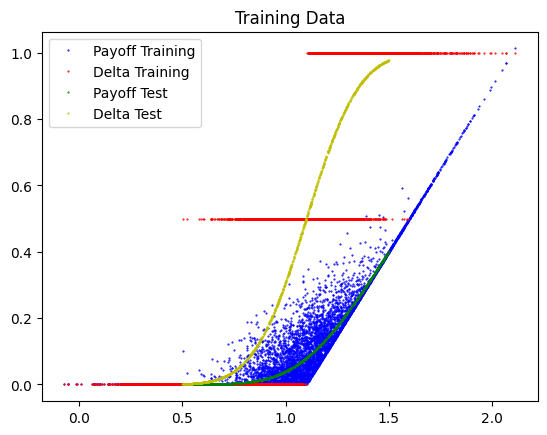

In [7]:
bach = BachelierBasic(1)
X, Y, Z, W = bach.trainingSet(10000, anti=True, seed=42)
print("-"*80)
print(X.shape)
print(Y.shape)
print(Z.shape)

print(W)

if 0:
    plt.title("Training Data Z test")
    for i, z in enumerate(Z):
        if i == 100:
            break
        plt.plot(X[:,0], z, 'b.', label='Payoff Training', markersize=1)
    plt.show()

spots, baskets, prices, deltas, vegas = bach.testSet(num=1000)

# plot training set:

def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, dydx_test):
    plt.title("Training Data")
    plt.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    plt.plot(x_train, dydx_train, 'r.', label='Delta Training', markersize=1)
    plt.plot(x_test, y_test, 'g.', label='Payoff Test', markersize=1)
    plt.plot(x_test, dydx_test, 'y.', label='Delta Test', markersize=1)
    plt.legend()
    plt.show()


plot_training_data(X[:,0], Y[:,0], Z[:,0], spots[:, 0], prices[:,0], deltas[:,0])
            

In [8]:
x = tf.constant(1.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.cos(x)

dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

-0.841471


(10000, 2)
(10000, 1)
(10000, 2)
(10000,)


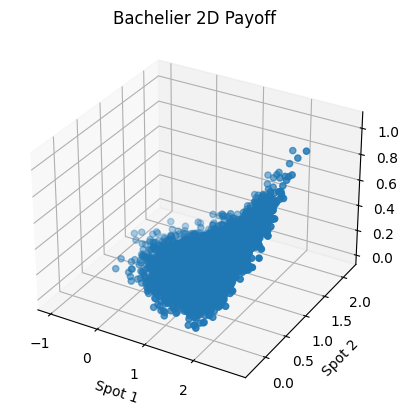

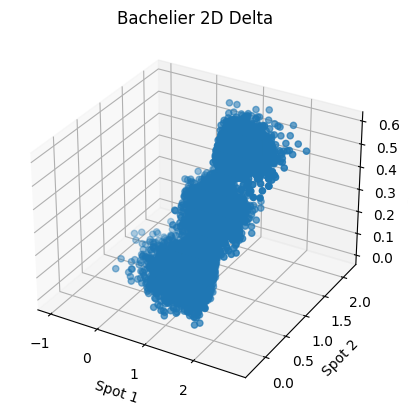

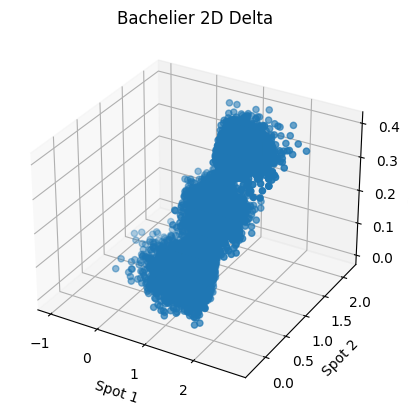

In [9]:
# 3d plot of Bachelier with 2 underlyings dimensions:

def plot_bachelier_3d(x, y, z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, marker='o')
    ax.set_xlabel('Spot 1')
    ax.set_ylabel('Spot 2')
    ax.set_zlabel('Payoff')
    ax.set_title(title)
    plt.show()

bach = Bachelier(2)
x, y, z = bach.trainingSet(10000)
print(x.shape)
print(y.shape)
print(z.shape)

print(x[:, 0].shape)

# plt.plot(x[:, 0], y, 'b.', label='Payoff', markersize=1)
# plt.show()
# plt.plot(x[:, 1], z[:, 1], 'r.', label='Delta 1', markersize=1)
# plt.show()
plot_bachelier_3d(x[:, 0], x[:, 1], y, "Bachelier 2D Payoff")
plot_bachelier_3d(x[:, 0], x[:, 1], z[:, 0], "Bachelier 2D Delta")
plot_bachelier_3d(x[:, 0], x[:, 1], z[:, 1], "Bachelier 2D Delta")

In [10]:
bach = Bachelier(7)
x_train, y_train, dydx_train = bach.trainingSet(N_TRAINING_SAMPLES)
spots, baskets, prices, deltas, vegas = bach.testSet(num=N_TEST_SAMPLES)

x_test = spots
y_test = prices
dydx_test = deltas

(4096, 7)
(8192, 1)


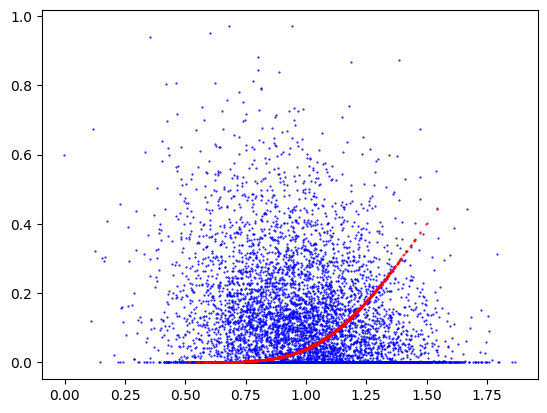

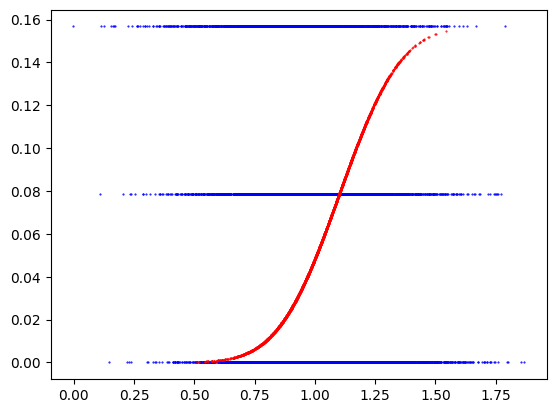

In [11]:
print(dydx_test.shape)
print(y_train.shape)

plt.plot(x_train[:, 0], y_train, 'b.', label='Payoff Train', markersize=1)
plt.plot(baskets, y_test, 'r.', label='Payoff Test', markersize=1)
plt.show()

plt.plot(x_train[:, 0], dydx_train[:, 1], 'b.', label='Delta Train', markersize=1)
plt.plot(baskets[:, 0], dydx_test[:, 1], 'r.', label='Payoff Test', markersize=1)

plt.show()


(8192, 1)
(4096, 7)
(8192, 1)


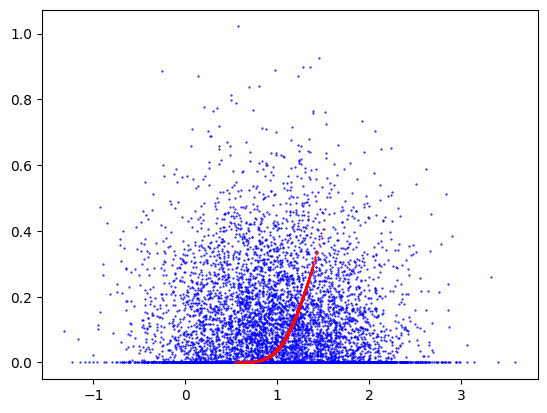

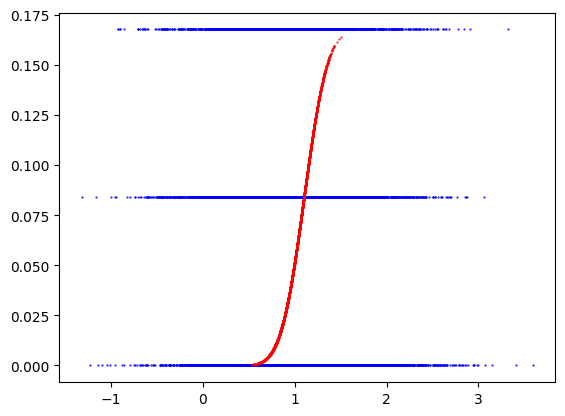

In [12]:
bach = BachelierBasic(7)
x_train, y_train, dydx_train, _ = bach.trainingSet(N_TRAINING_SAMPLES)
spots, baskets, prices, deltas, vegas = bach.testSet(num=N_TEST_SAMPLES)

x_test = spots
y_test = prices
dydx_test = deltas

print(dydx_test.shape)
print(y_train.shape)

plt.plot(x_train[:, 0], y_train, 'b.', label='Payoff Train', markersize=1)
plt.plot(baskets, y_test, 'r.', label='Payoff Test', markersize=1)
plt.show()

plt.plot(x_train[:, 0], dydx_train[:, 1], 'b.', label='Delta Train', markersize=1)
plt.plot(baskets[:, 0], dydx_test[:, 1], 'r.', label='Payoff Test', markersize=1)

plt.show()

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE) 

In [14]:
x_normalizer = tf.keras.layers.Normalization()
x_normalizer.adapt(x_train)

y_denormalizer = tf.keras.layers.Normalization(invert=True)
y_denormalizer.adapt(y_train)

input_shape = x_train.shape[1:]
# create a new model
vanilla_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    x_normalizer,
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(1),
    y_denormalizer
], name="SurrogateModelWithoutDifferentials")


optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_metric = tf.keras.metrics.Mean(name='train_loss')
loss_fn = tf.keras.losses.MeanSquaredError()

vanilla_model.compile(optimizer=optimizer, loss=loss_fn)

def loss(model, x, y):
    y_pred = model(x)
    return loss_fn(y_true=y, y_pred=y_pred)


@tf.function
def train_step(model, x, y, dydx):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    loss_metric.update_state(loss_value)

for epoch in range(NUM_EPOCHS):
    loss_metric.reset_states()

    for xs, ys, dydxs in train_dataset:
        train_step(vanilla_model, xs, ys, dydxs)
    
    mean_loss = loss_metric.result()

    print('Finished epoch {:3d}'.format(epoch), ' |  Loss: {:.5f}'.format(mean_loss))


Finished epoch   0  |  Loss: 0.00734
Finished epoch   1  |  Loss: 0.00174
Finished epoch   2  |  Loss: 0.00148
Finished epoch   3  |  Loss: 0.00144
Finished epoch   4  |  Loss: 0.00142
Finished epoch   5  |  Loss: 0.00140
Finished epoch   6  |  Loss: 0.00140
Finished epoch   7  |  Loss: 0.00141
Finished epoch   8  |  Loss: 0.00138
Finished epoch   9  |  Loss: 0.00139
Finished epoch  10  |  Loss: 0.00138
Finished epoch  11  |  Loss: 0.00138
Finished epoch  12  |  Loss: 0.00138
Finished epoch  13  |  Loss: 0.00138
Finished epoch  14  |  Loss: 0.00137
Finished epoch  15  |  Loss: 0.00137
Finished epoch  16  |  Loss: 0.00138
Finished epoch  17  |  Loss: 0.00137
Finished epoch  18  |  Loss: 0.00137
Finished epoch  19  |  Loss: 0.00137
Finished epoch  20  |  Loss: 0.00139
Finished epoch  21  |  Loss: 0.00136
Finished epoch  22  |  Loss: 0.00137
Finished epoch  23  |  Loss: 0.00136
Finished epoch  24  |  Loss: 0.00136
Finished epoch  25  |  Loss: 0.00135
Finished epoch  26  |  Loss: 0.00137
F

128/128 [==============================] - 0s 1ms/step
RMSE 0.009533743374049664


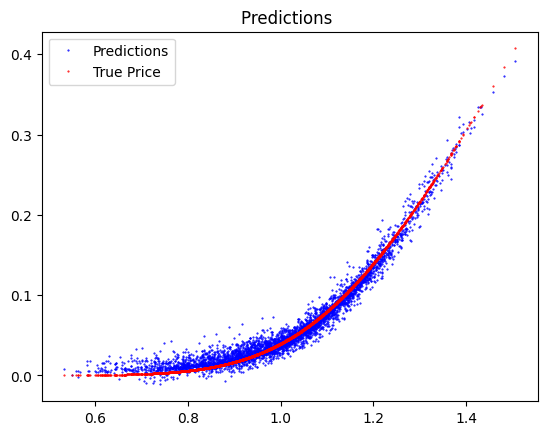

In [15]:
vanilla_pred_y = vanilla_model.predict(x_test)

test_rmse = tf.sqrt(vanilla_model.loss(y_test, vanilla_pred_y))
print(f"RMSE {test_rmse}")

plt.title("Predictions ")
plt.plot(baskets, vanilla_pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()

RMSE 0.009533743374049664


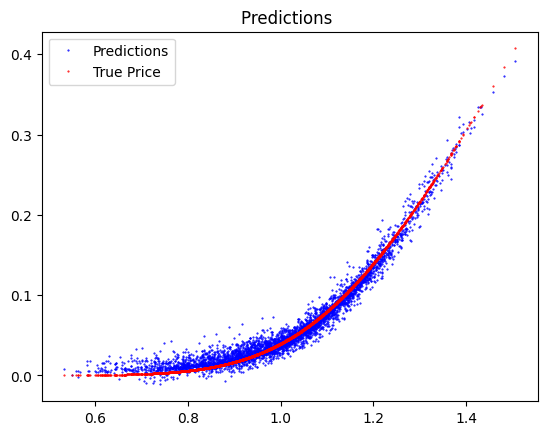

RMSE 0.01833832450211048


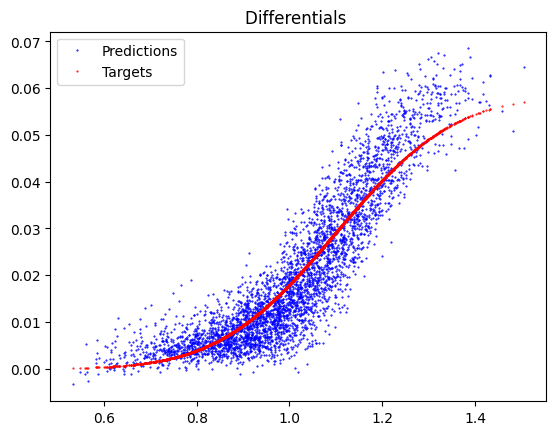

In [17]:
@tf.function
def eval(model, x, y, dydx):
    with tf.GradientTape() as t:
        t.watch(x)
        y_pred = model(x)

    dydx_pred = t.batch_jacobian(y_pred, x)
    dydx_pred = tf.squeeze(dydx_pred, axis=1)

    y_loss = loss_fn(y_pred, y)
    dydx_loss = loss_fn(dydx_pred, dydx)
    return y_pred, dydx_pred, y_loss, dydx_loss

vanilla_pred_y, vanilla_pred_dydx, vanilla_y_loss, vanilla_dydx_loss = eval(vanilla_model, x_test, y_test, dydx_test)

test_rmse = tf.sqrt(vanilla_y_loss)
print(f"RMSE {test_rmse}")

plt.title("Predictions ")
plt.plot(baskets, vanilla_pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = tf.sqrt(vanilla_dydx_loss)
print(f"RMSE {deltas_rmse}")

plt.title("Differentials ")
dydx_idx = 0
plt.plot(baskets, vanilla_pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Predictions', 'Targets'], loc='upper left')
plt.show()

Differential ML

In [18]:
x_normalizer = tf.keras.layers.Normalization()
x_normalizer.adapt(x_train)

y_denormalizer = tf.keras.layers.Normalization(invert=True)
y_denormalizer.adapt(y_train)

input_shape = x_train.shape[1:]
# create a new model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    x_normalizer,
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(1),
    y_denormalizer
], name="SurrogateModelWithDifferentials")

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

y_loss_metric = tf.keras.metrics.Mean(name='y_loss')
total_loss_metric = tf.keras.metrics.Mean(name='total_loss')

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn)

def loss(y_pred, y_true, dydx_pred, dydx_true):
    y_loss = loss_fn(y_true, y_pred)
    dy_loss = loss_fn(dydx_true, dydx_pred)

    alpha = 0.5
    beta = 1 - alpha
    return y_loss, alpha * y_loss + beta * dy_loss

@tf.function
def train_step(model, x, y, dydx):
    with tf.GradientTape() as t1, tf.GradientTape() as t2:
        t1.watch(x)
        t2.watch(x)
        y_pred = model(x)

        dydx_pred = t2.batch_jacobian(y_pred, x)
        dydx_pred = tf.squeeze(dydx_pred, axis=1)

        y_loss, total_loss = loss(y_pred, y, dydx_pred, dydx)
 
    grads = t1.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    y_loss_metric.update_state(y_loss)
    total_loss_metric.update_state(total_loss)

for epoch in range(NUM_EPOCHS):
    y_loss_metric.reset_states()
    total_loss_metric.reset_states()

    for xs, ys, dydxs in train_dataset:
        train_step(model, xs, ys, dydxs)

    mean_loss = y_loss_metric.result()
    mean_total_loss = total_loss_metric.result()
    print('Finished epoch {:3d}'.format(epoch), 
          ' | y-loss: {:.5f}'.format(mean_loss),  
          ' | total-loss: {:.5f}'.format(mean_total_loss))



Finished epoch   0  | y-loss: 0.00745  | total-loss: 0.00574
Finished epoch   1  | y-loss: 0.00171  | total-loss: 0.00144
Finished epoch   2  | y-loss: 0.00145  | total-loss: 0.00118
Finished epoch   3  | y-loss: 0.00141  | total-loss: 0.00112
Finished epoch   4  | y-loss: 0.00140  | total-loss: 0.00111
Finished epoch   5  | y-loss: 0.00139  | total-loss: 0.00109
Finished epoch   6  | y-loss: 0.00139  | total-loss: 0.00108
Finished epoch   7  | y-loss: 0.00138  | total-loss: 0.00108
Finished epoch   8  | y-loss: 0.00138  | total-loss: 0.00107
Finished epoch   9  | y-loss: 0.00137  | total-loss: 0.00107
Finished epoch  10  | y-loss: 0.00137  | total-loss: 0.00106
Finished epoch  11  | y-loss: 0.00137  | total-loss: 0.00106
Finished epoch  12  | y-loss: 0.00138  | total-loss: 0.00107
Finished epoch  13  | y-loss: 0.00137  | total-loss: 0.00106
Finished epoch  14  | y-loss: 0.00137  | total-loss: 0.00106
Finished epoch  15  | y-loss: 0.00137  | total-loss: 0.00106
Finished epoch  16  | y-

RMSE 0.003947489894926548


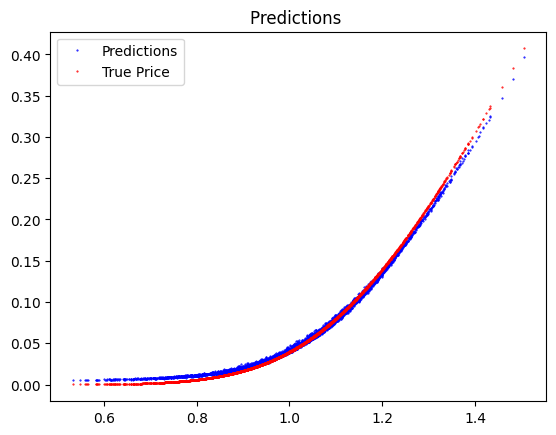

RMSE 0.0043502142652869225


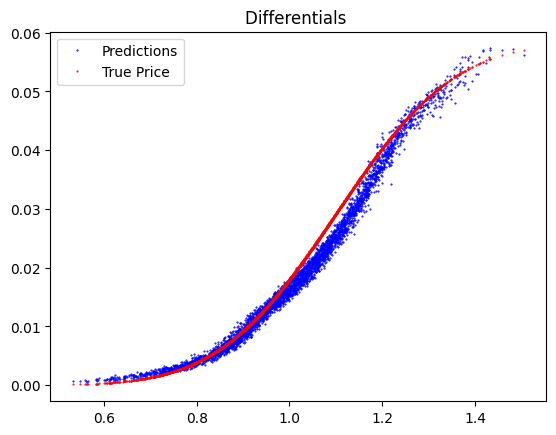

In [19]:
@tf.function
def eval(model, x, y, dydx):
    with tf.GradientTape() as t:
        t.watch(x)
        y_pred = model(x)

    dydx_pred = t.batch_jacobian(y_pred, x)
    dydx_pred = tf.squeeze(dydx_pred, axis=1)

    y_loss, total_loss = loss(y_pred, y, dydx_pred, dydx)
    return y_pred, dydx_pred, y_loss, total_loss

pred_y, pred_dydx, y_loss, total_loss = eval(model, x_test, y_test, dydx_test)

test_rmse = tf.sqrt(y_loss)
print(f"RMSE {test_rmse}")

plt.title("Predictions ")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = tf.sqrt(model.loss(dydx_test, pred_dydx))
print(f"RMSE {deltas_rmse}")

plt.title("Differentials ")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()

PCA

In [24]:
import numpy as np

dydx_pred_means.shape:  (7,)
dydx_pred_means:  tf.Tensor(
[ 0.00202946 -0.03647003  0.11894199 -0.00819313  0.04030885 -0.0113889
  0.0447055 ], shape=(7,), dtype=float32)
dydx_pred_mean_adjusted.shape:  (256, 7)
tf.Tensor(0.0008548825, shape=(), dtype=float32)
tf.Tensor(0.9619401, shape=(), dtype=float32)


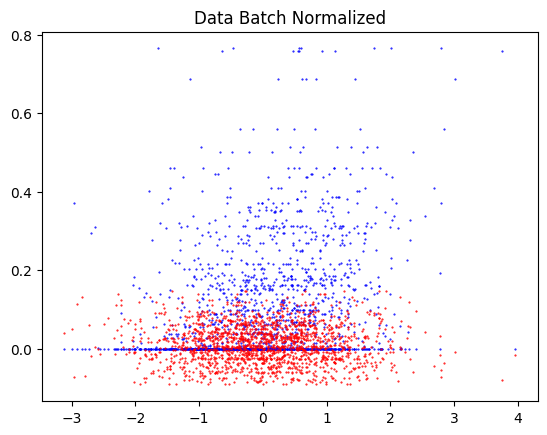

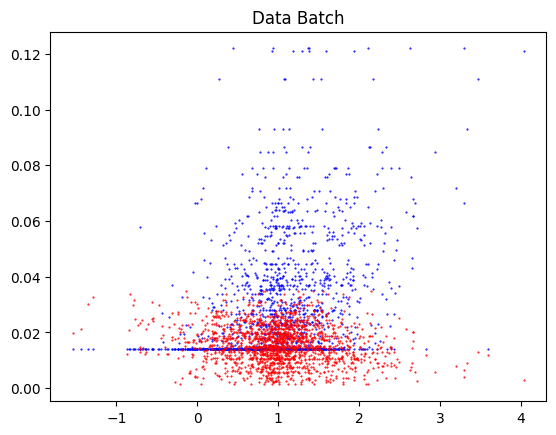

dydx_pred rank is: 2
mean of dydx_pred:  tf.Tensor(0.021419104, shape=(), dtype=float32)
sanity checks
U @ U.T =  tf.Tensor(
[[ 1.00000012e+00 -2.98023224e-08 -2.39815563e-08 -1.11758709e-08
  -9.68575478e-08 -9.31322575e-09  5.21540642e-08]
 [-2.98023224e-08  1.00000012e+00  1.30385160e-08  1.49011612e-07
   7.45058060e-08  1.11758709e-08  8.94069672e-08]
 [-2.39815563e-08  1.30385160e-08  1.00000012e+00 -7.45058060e-09
   1.17346644e-07  7.45058060e-09 -3.35276127e-08]
 [-1.11758709e-08  1.49011612e-07 -7.45058060e-09  1.00000012e+00
   2.98023224e-08 -5.96046448e-08  0.00000000e+00]
 [-9.68575478e-08  7.45058060e-08  1.17346644e-07  2.98023224e-08
   9.99999881e-01 -2.23517418e-08 -2.14204192e-08]
 [-9.31322575e-09  1.11758709e-08  7.45058060e-09 -5.96046448e-08
  -2.23517418e-08  9.99999940e-01 -2.23517418e-08]
 [ 5.21540642e-08  8.94069672e-08 -3.35276127e-08  0.00000000e+00
  -2.14204192e-08 -2.23517418e-08  1.00000000e+00]], shape=(7, 7), dtype=float32)
V @ V.T =  tf.Tensor(
[[ 

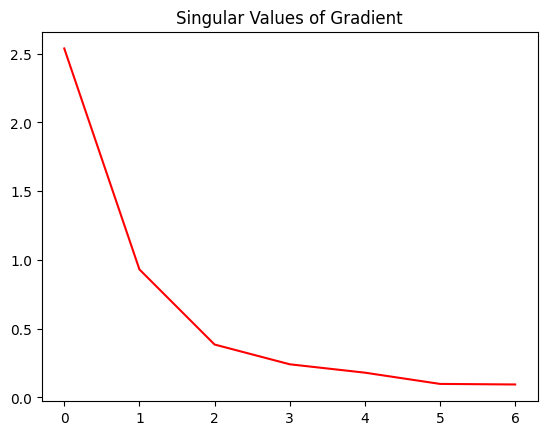

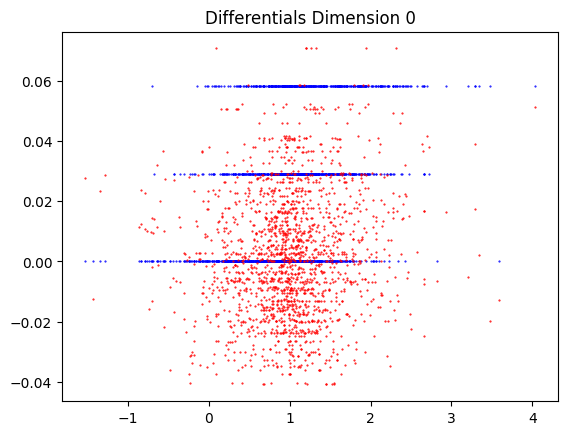

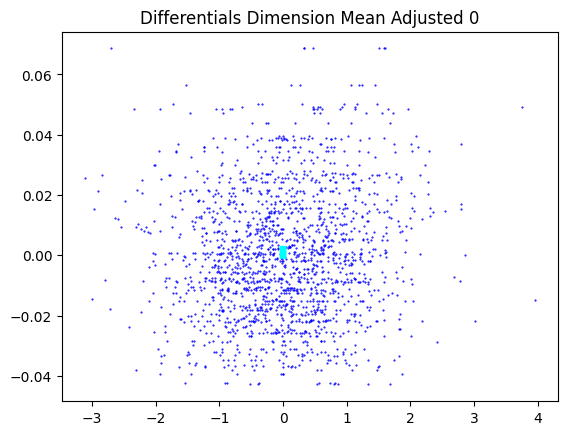

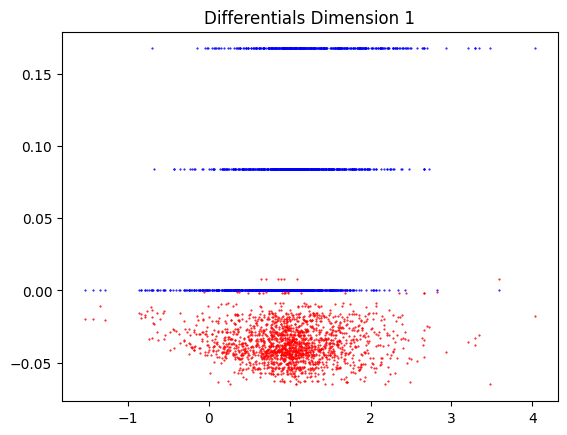

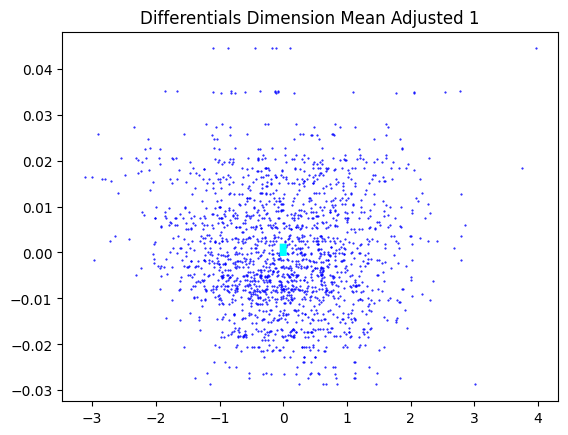

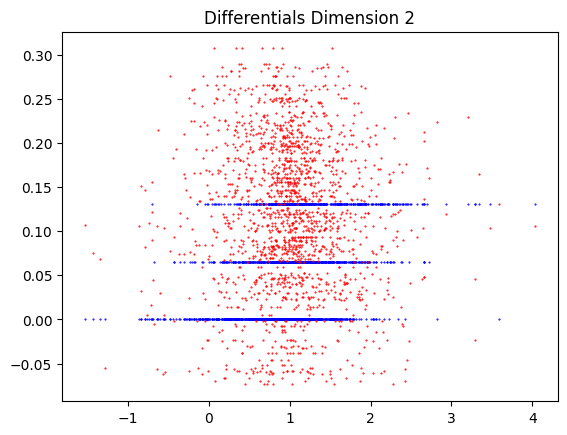

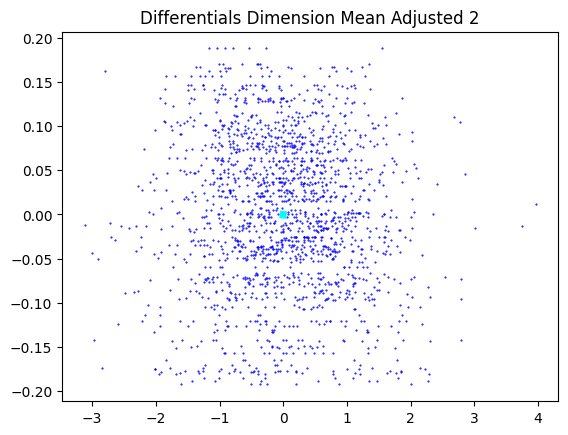

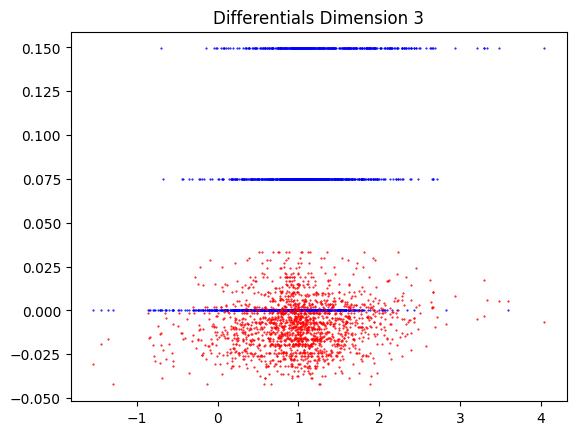

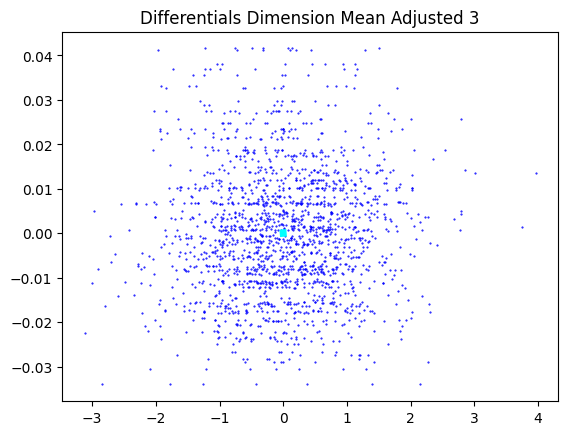

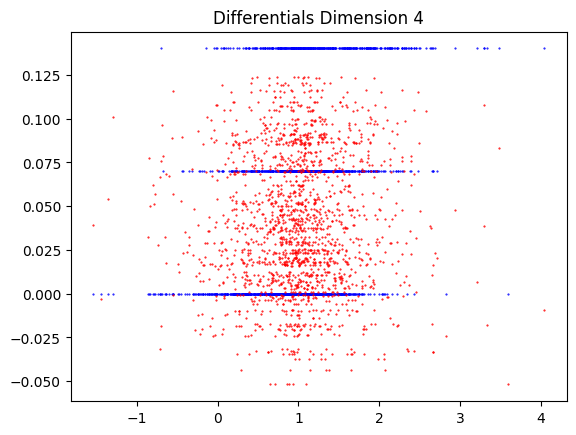

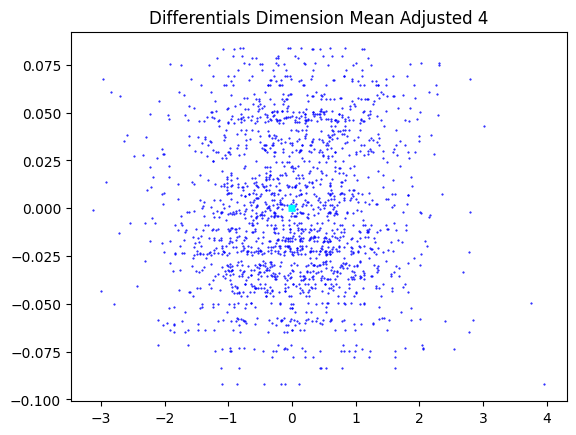

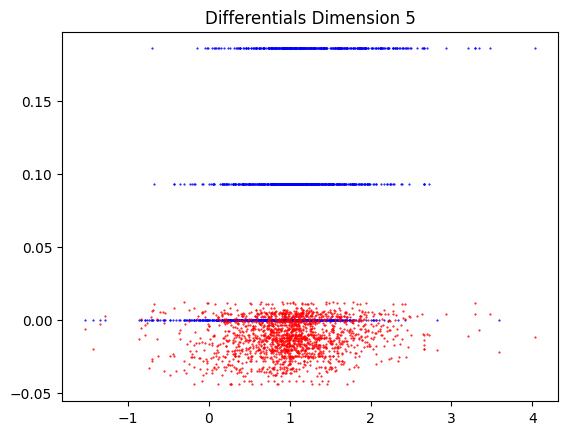

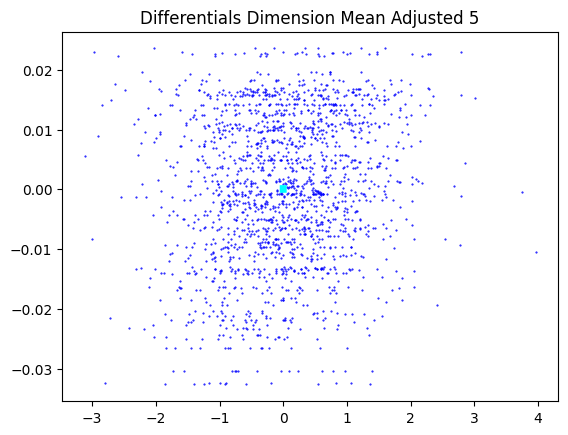

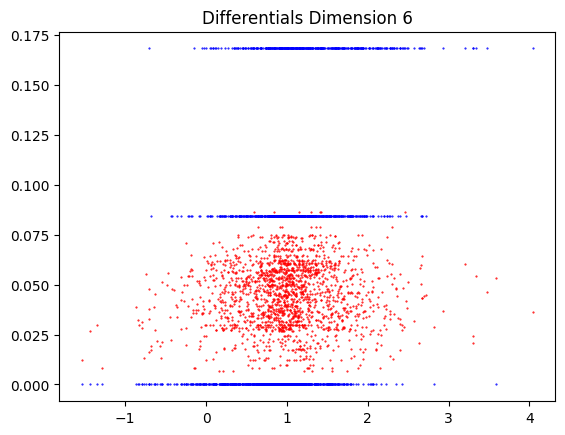

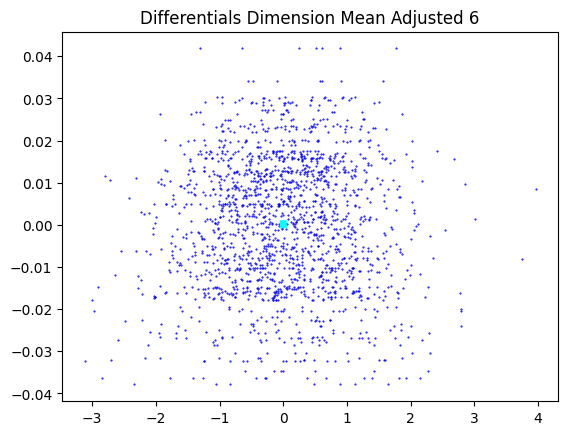

dydx_pred_means.shape:  (7,)
dydx_pred_means:  tf.Tensor(
[ 0.01193071 -0.00773772  0.00520723  0.01230992  0.03665632  0.00995558
  0.03666083], shape=(7,), dtype=float32)
dydx_pred_mean_adjusted.shape:  (256, 7)
tf.Tensor(-0.0035214562, shape=(), dtype=float32)
tf.Tensor(1.0058694, shape=(), dtype=float32)


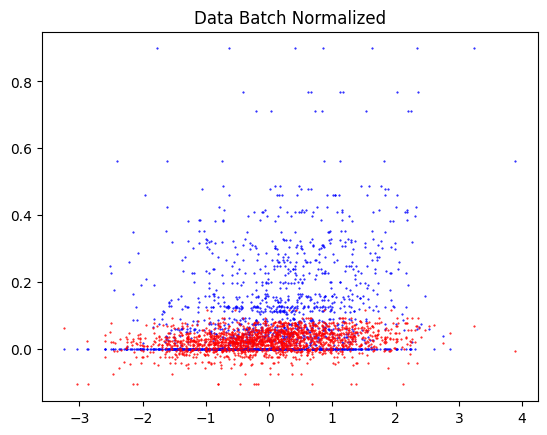

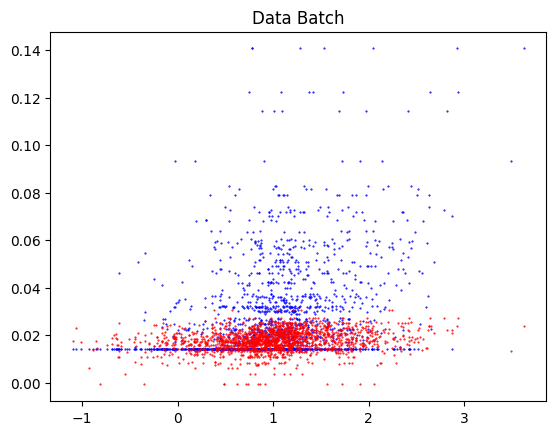

dydx_pred rank is: 2
mean of dydx_pred:  tf.Tensor(0.014997552, shape=(), dtype=float32)
sanity checks
U @ U.T =  tf.Tensor(
[[ 1.0000000e+00 -2.9802322e-08  6.1932951e-08 -7.4505806e-09
  -7.4505806e-09  1.4901161e-08 -5.1222742e-08]
 [-2.9802322e-08  1.0000001e+00  8.5681677e-08  2.1886081e-07
  -2.9802322e-08  2.7939677e-08  8.1956387e-08]
 [ 6.1932951e-08  8.5681677e-08  1.0000004e+00 -2.9802322e-08
   1.6484410e-07  2.6077032e-08 -3.3527613e-08]
 [-7.4505806e-09  2.1886081e-07 -2.9802322e-08  9.9999964e-01
   1.4901161e-08 -3.8649887e-08 -2.9802322e-08]
 [-7.4505806e-09 -2.9802322e-08  1.6484410e-07  1.4901161e-08
   1.0000001e+00  4.4703484e-08 -1.1175871e-07]
 [ 1.4901161e-08  2.7939677e-08  2.6077032e-08 -3.8649887e-08
   4.4703484e-08  9.9999976e-01  1.8626451e-08]
 [-5.1222742e-08  8.1956387e-08 -3.3527613e-08 -2.9802322e-08
  -1.1175871e-07  1.8626451e-08  1.0000001e+00]], shape=(7, 7), dtype=float32)
V @ V.T =  tf.Tensor(
[[ 0.03120662  0.00179869  0.02083251 ...  0.0054437

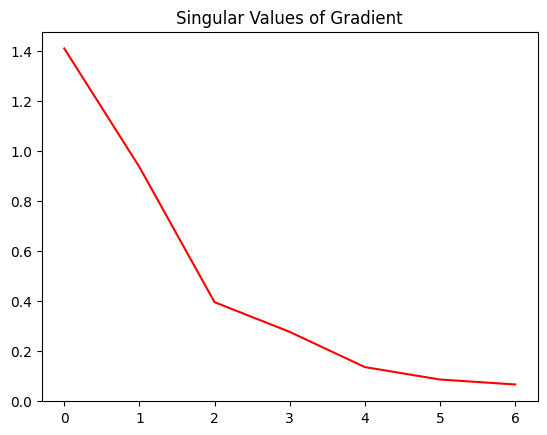

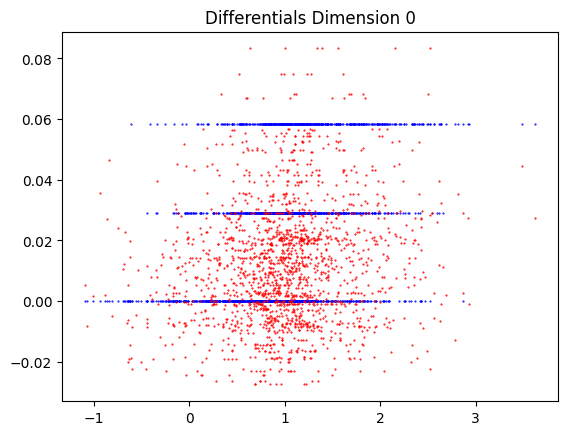

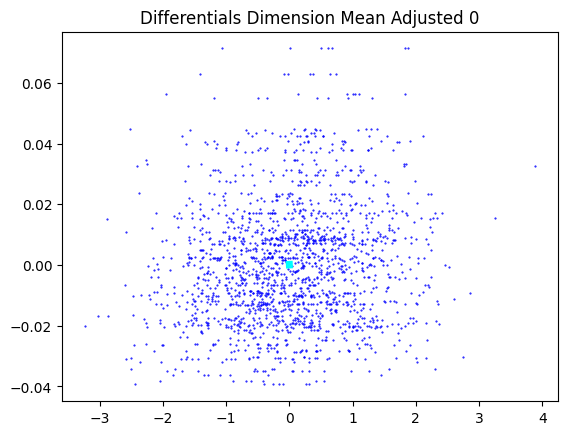

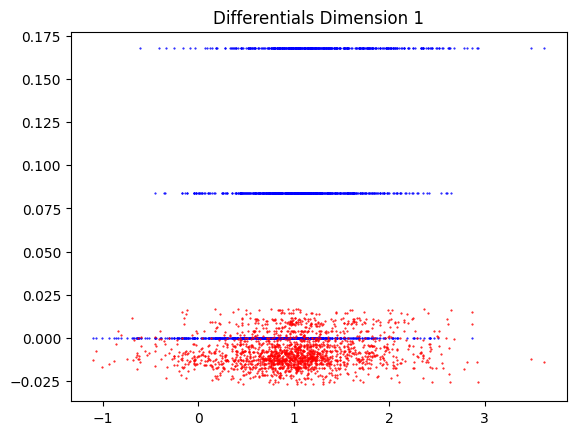

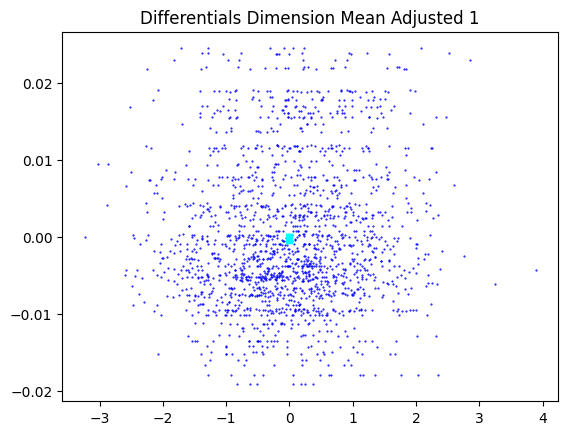

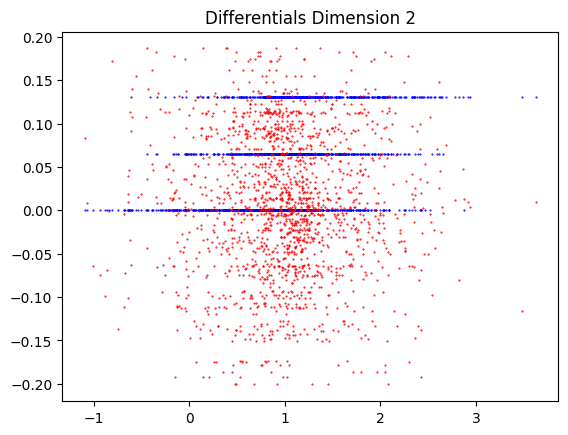

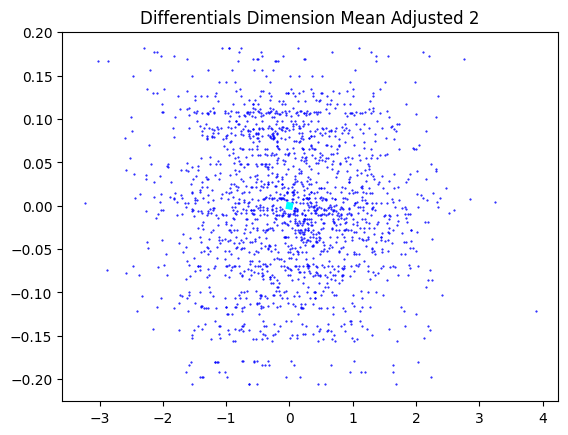

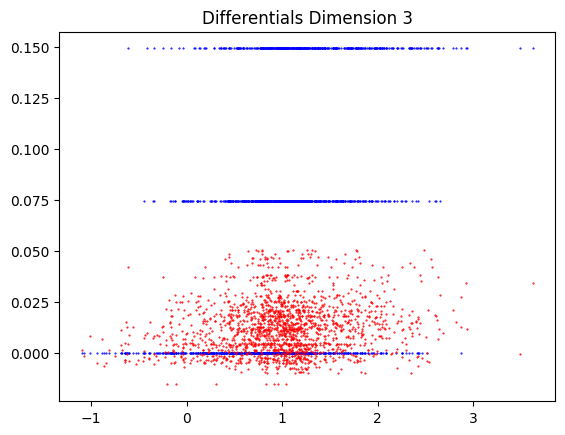

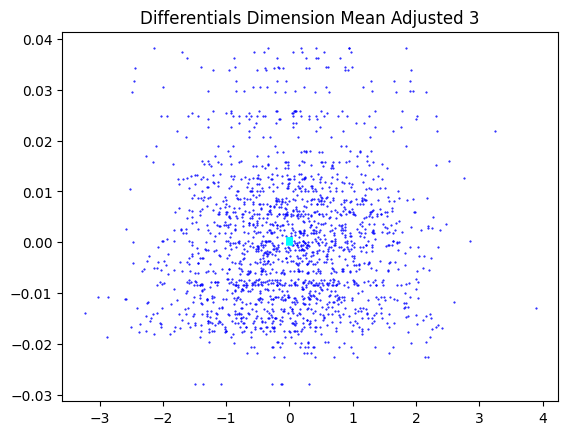

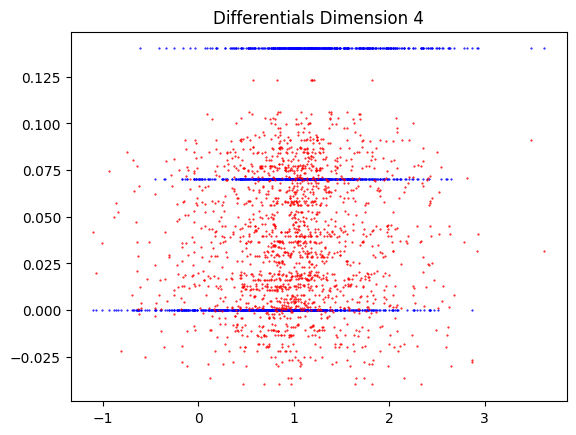

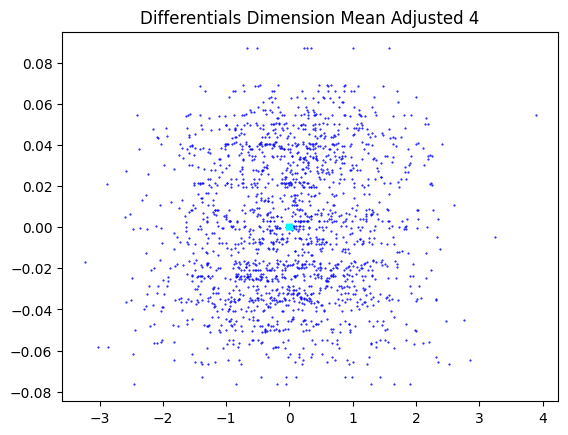

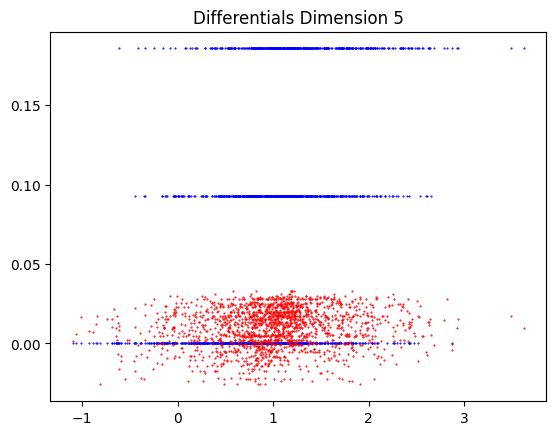

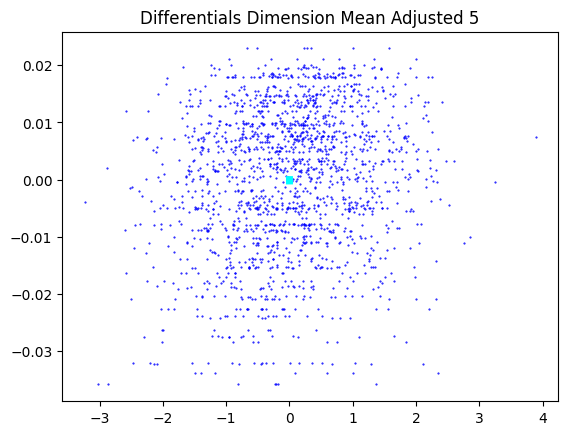

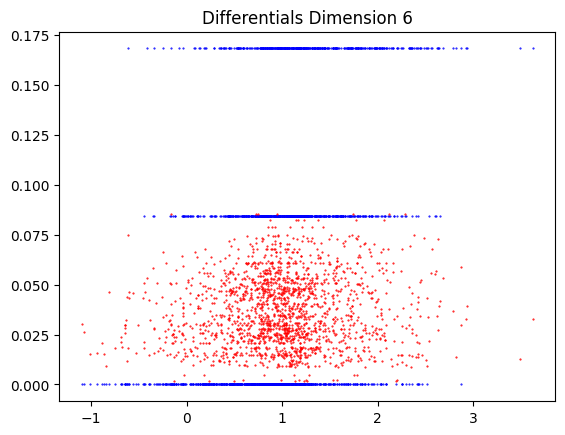

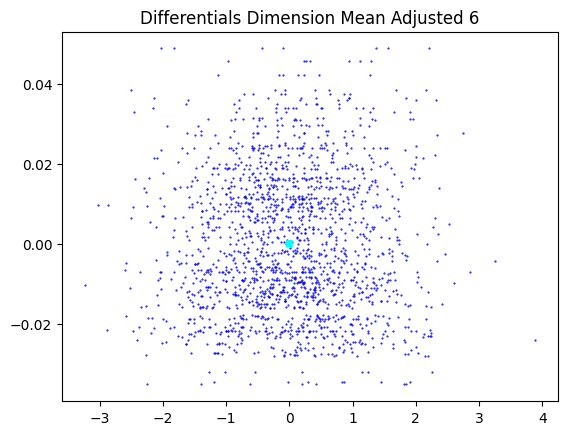

dydx_pred_means.shape:  (7,)
dydx_pred_means:  tf.Tensor(
[0.01245932 0.01740623 0.01260233 0.02863855 0.0419458  0.02812423
 0.03737646], shape=(7,), dtype=float32)
dydx_pred_mean_adjusted.shape:  (256, 7)
tf.Tensor(-0.013584268, shape=(), dtype=float32)
tf.Tensor(1.0046889, shape=(), dtype=float32)


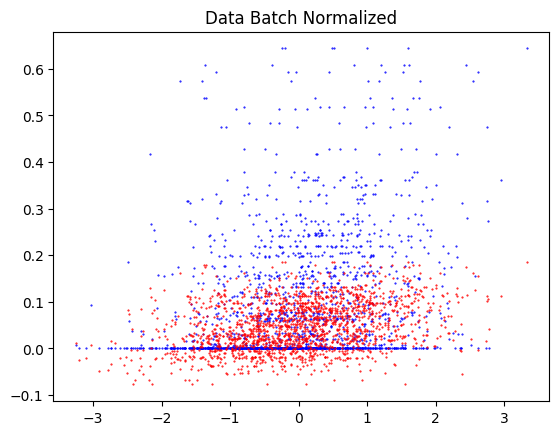

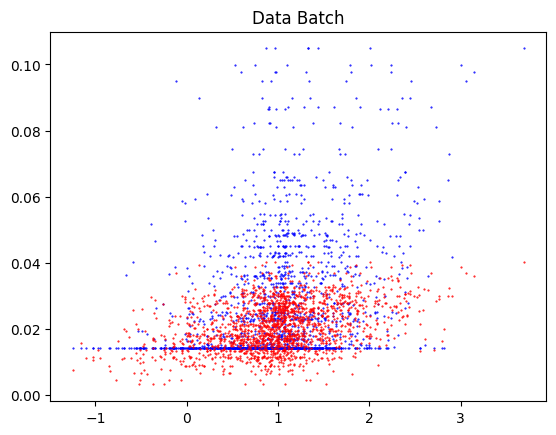

dydx_pred rank is: 2
mean of dydx_pred:  tf.Tensor(0.025507564, shape=(), dtype=float32)
sanity checks
U @ U.T =  tf.Tensor(
[[ 1.0000000e+00  8.9406967e-08 -6.9849193e-09 -5.4016709e-08
  -5.0291419e-08  7.4505806e-09 -4.4703484e-08]
 [ 8.9406967e-08  1.0000000e+00  1.0803342e-07 -5.9604645e-08
  -1.4901161e-08  2.9802322e-08 -1.1175871e-07]
 [-6.9849193e-09  1.0803342e-07  1.0000004e+00 -1.3411045e-07
  -1.8742867e-08 -1.7695129e-08 -1.0430813e-07]
 [-5.4016709e-08 -5.9604645e-08 -1.3411045e-07  1.0000001e+00
  -1.4901161e-08 -5.2154064e-08  1.1920929e-07]
 [-5.0291419e-08 -1.4901161e-08 -1.8742867e-08 -1.4901161e-08
   1.0000000e+00  0.0000000e+00 -1.4482066e-07]
 [ 7.4505806e-09  2.9802322e-08 -1.7695129e-08 -5.2154064e-08
   0.0000000e+00  9.9999982e-01  5.9604645e-08]
 [-4.4703484e-08 -1.1175871e-07 -1.0430813e-07  1.1920929e-07
  -1.4482066e-07  5.9604645e-08  1.0000000e+00]], shape=(7, 7), dtype=float32)
V @ V.T =  tf.Tensor(
[[ 0.02864938 -0.00589806 -0.00609478 ...  0.0128786

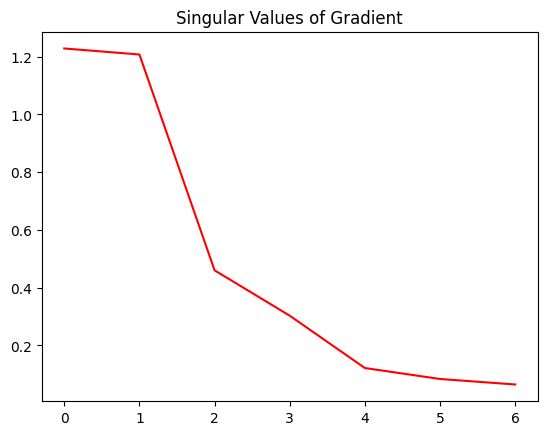

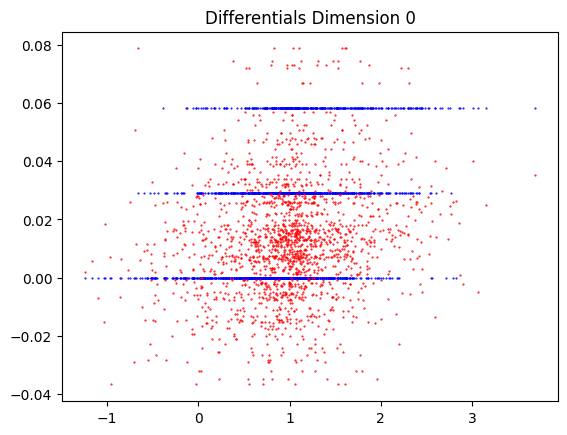

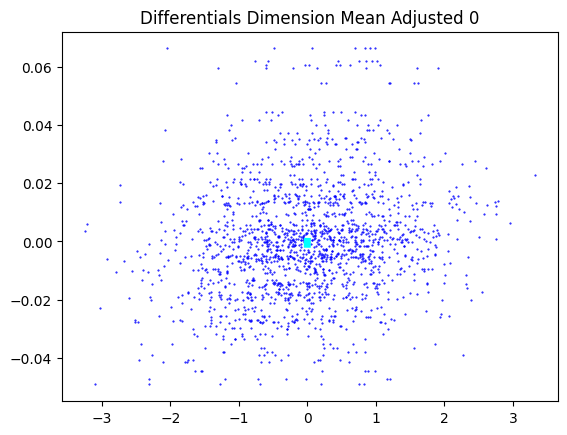

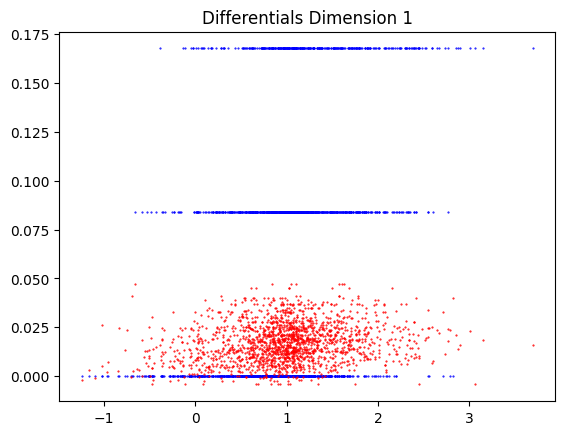

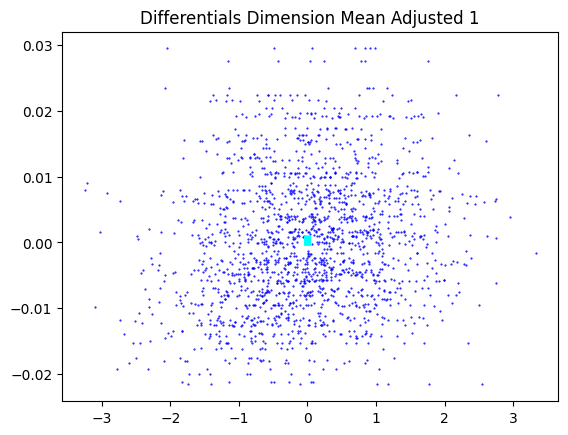

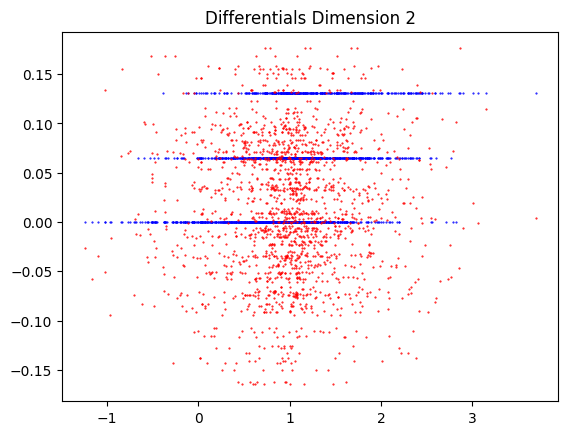

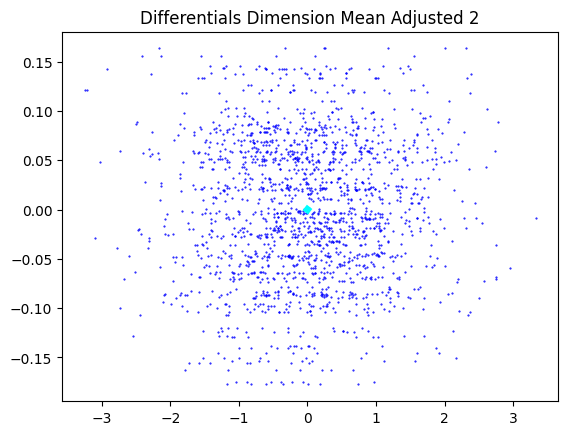

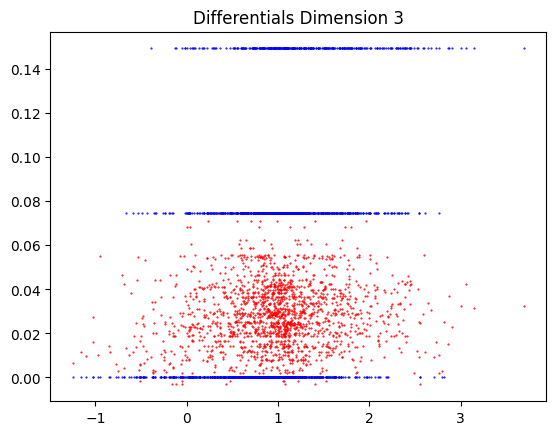

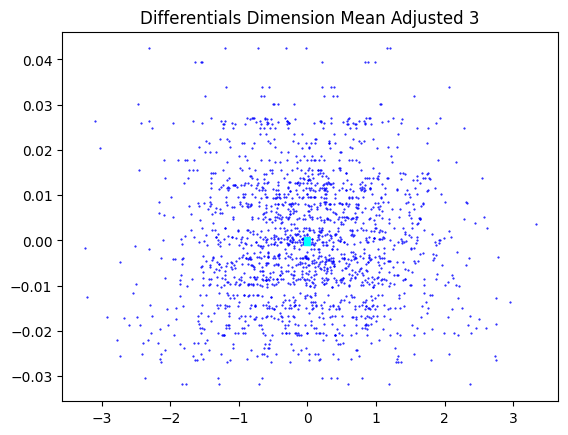

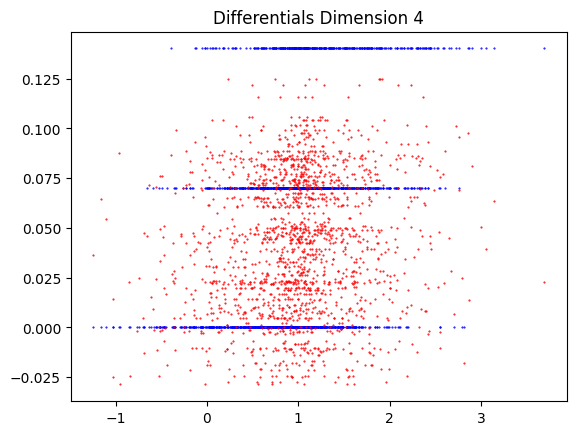

KeyboardInterrupt: 

In [42]:
x_normalizer = tf.keras.layers.Normalization()
x_normalizer.adapt(x_train)

y_denormalizer = tf.keras.layers.Normalization(invert=True)
y_denormalizer.adapt(y_train)

input_shape = x_train.shape[1:]
# create a new model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    x_normalizer,
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(1),
    y_denormalizer
], name="SurrogateModelWithDifferentialsAndPCA")

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

y_loss_metric = tf.keras.metrics.Mean(name='y_loss')
total_loss_metric = tf.keras.metrics.Mean(name='total_loss')

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn)

def loss(y_pred, y_true, dydx_pred, dydx_true):
    y_loss = loss_fn(y_true, y_pred)
    dy_loss = loss_fn(dydx_true, dydx_pred)

    alpha = 0.5
    beta = 1 - alpha
    return y_loss, alpha * y_loss + beta * dy_loss

# @tf.function
def train_step(model, x, y, dydx, epoch):
    with tf.GradientTape() as t1, tf.GradientTape() as t2:
        t1.watch(x)
        t2.watch(x)
        y_pred = model(x)

        dydx_pred = t2.batch_jacobian(y_pred, x)
        dydx_pred = tf.squeeze(dydx_pred, axis=1)
        # print(dydx_pred)

        # plot the differentials during training loop:
        with t1.stop_recording():

            dydx_pred_means = tf.math.reduce_mean(dydx_pred, axis=0)
            print("dydx_pred_means.shape: ", dydx_pred_means.shape)
            print("dydx_pred_means: ", dydx_pred_means)

            dydx_pred_mean_adjusted = dydx_pred - tf.tile(tf.expand_dims(dydx_pred_means, axis=0), [dydx_pred.shape[0], 1])
            print("dydx_pred_mean_adjusted.shape: ", dydx_pred_mean_adjusted.shape)

            x_scaled = x_normalizer(x)
            y_denormalized = y_denormalizer(y)
            y_denormalized_pred = y_denormalizer(y_pred)

            # print(x_scaled.mean())
            print(tf.math.reduce_mean(x_scaled))
            print(tf.math.reduce_std(x_scaled))

            # plot data batch:
            if (epoch % 5 == 0):
                plt.title("Data Batch Normalized")
                plt.plot(x_scaled, y, 'b.', markersize=1)
                plt.plot(x_scaled, y_pred, 'r.', markersize=1)
                plt.show()

                plt.title("Data Batch")
                plt.plot(x, y_denormalized, 'b.', markersize=1)
                plt.plot(x, y_denormalized_pred, 'r.', markersize=1)
                plt.show()


            print(f"dydx_pred rank is: {tf.rank(dydx_pred)}")

            print("mean of dydx_pred: ", tf.math.reduce_mean(dydx_pred))

            S, U, V = tf.linalg.svd(dydx_pred, full_matrices=False)

            temp = U
            U = V
            V = temp
            
            print("sanity checks")
            print("U @ U.T = ", U @ tf.transpose(U))
            print("V @ V.T = ", V @ tf.transpose(V))
            print("S = ", S)

            # 1 std dev confidence interval:
            theta = 2 * PI * tf.range(0, 1, 0.01)
            principle_components = (U @ tf.linalg.diag(S)) #/ x.shape[0]  #@ tf.Tensor([tf.cos(theta), tf.sin(theta)])
            tf_cos = tf.cos(theta)
            tf_sin = tf.sin(theta)
            # circle = tf.Tensor([tf_cos, tf_sin])
            # y_pred_std = y_pred_std @ circle

            # print(s)

            plt.title("Singular Values of Gradient")
            plt.plot(S, 'r', markersize=1)
            plt.show()

            # print(f"out rank is: {tf.rank(s)}")

            if (epoch % 5 == 0):
                for i in range(x.shape[1]):
                    # tf.print("helo")
                    # tf.print(dydx_pred[:, i])
                    # print(i)
                    # plt.plot(x.numpy(), dydx_pred[:, i].numpy(), 'r.', markersize=1)

                    plt.title(f"Differentials Dimension {i}")
                    plt.plot(x, dydx[:, i], 'b.', markersize=1)
                    plt.plot(x, dydx_pred[:, i], 'r.', markersize=1)

                    # plot the principal components:
                    # plt.plot([0, 0 + U[0, 0]*S[0]], y_pred_std[:, i], 'g.', markersize=1)

                    # plt.plot(principle_components[:, i], '-', color='cyan', linewidth=5)
                    plt.show()


                    plt.title(f"Differentials Dimension Mean Adjusted {i}")
                    plt.plot(x_scaled, dydx_pred_mean_adjusted[:, i], 'b.', markersize=1)
                    plt.plot(np.array([0, 0 + principle_components[0, i]]), 
                             np.array([0, 0 + principle_components[1, i]]), '-', color='cyan', linewidth=5)

                    plt.show()


        # with t1.stop_recording():
        #     plt.title("Differentials ")
        #     for i in range(x.shape[1]):
        #         # tf.print("helo")
        #         # tf.print(dydx_pred[:, i])
        #         # print(i)
        #         plt.plot(x.numpy(), dydx[:, i].numpy(), 'r.', markersize=1)
        #     plt.show()

        y_loss, total_loss = loss(y_pred, y, dydx_pred, dydx)
 
    grads = t1.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    y_loss_metric.update_state(y_loss)
    total_loss_metric.update_state(total_loss)

for epoch in range(NUM_EPOCHS):
    y_loss_metric.reset_states()
    total_loss_metric.reset_states()

    for xs, ys, dydxs in train_dataset:
        train_step(model, xs, ys, dydxs, epoch)

    mean_loss = y_loss_metric.result()
    mean_total_loss = total_loss_metric.result()
    print('Finished epoch {:3d}'.format(epoch), 
          ' | y-loss: {:.5f}'.format(mean_loss),  
          ' | total-loss: {:.5f}'.format(mean_total_loss))



In [ ]:
x_normalizer = tf.keras.layers.Normalization()
x_normalizer.adapt(x_train)

y_denormalizer = tf.keras.layers.Normalization(invert=True)
y_denormalizer.adapt(y_train)

input_shape = x_train.shape[1:]
# create a new model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    x_normalizer,
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(1),
    y_denormalizer
], name="SurrogateModelWithDifferentials")

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

y_loss_metric = tf.keras.metrics.Mean(name='y_loss')
dydx_loss_metric = tf.keras.metrics.Mean(name='dydx_loss')
ddyddx_loss_metric = tf.keras.metrics.Mean(name='ddyddx_loss')
total_loss_metric = tf.keras.metrics.Mean(name='total_loss')

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn)

def loss(y_pred, y_true, dydx_pred, dydx_true, ddyddx_pred, ddyddx_true, epoch):
    y_loss = loss_fn(y_true, y_pred)
    dy_loss = loss_fn(dydx_true, dydx_pred)
    ddyddx_loss = loss_fn(ddyddx_true, ddyddx_pred)

    alpha = 0.7
    beta = 0.3
    gamma = 0.0

    if epoch > 60:
        alpha = 0.5
        beta = 0.5

    if epoch > 80:
        alpha = 0.8
        beta = 0.0
        gamma = 0.2

    # if epoch > 30:
    #     beta = 0.3
    #     gamma = 0.1
    
    # if epoch > 60:
    #     beta = 0.2
    #     gamma = 0.2

    # if epoch > 90:
    #     beta = 0.1
    #     gamma = 0.3

    total_loss = alpha * y_loss + beta * dy_loss + gamma * ddyddx_loss
    return y_loss, dy_loss, ddyddx_loss, total_loss

@tf.function
def train_step(model, x, y, dydx, epoch):

    with tf.GradientTape() as loss_tape:
        loss_tape.watch(x)
        with tf.GradientTape() as hess_tape:
            hess_tape.watch(x)
            with tf.GradientTape() as grad_tape:
                grad_tape.watch(x)
                y_pred = model(x)

            dydx_pred = grad_tape.batch_jacobian(y_pred, x)
            dydx_pred = tf.squeeze(dydx_pred, axis=1)

        ddyddx_pred = hess_tape.batch_jacobian(dydx_pred, x)
        # print(tf.reduce_sum(ddyddx_pred))
        # print(tf.reduce_max(ddyddx_pred))
        y_loss, dy_loss, dydx_loss, total_loss = loss(y_pred, y, dydx_pred, dydx, ddyddx_pred, tf.zeros_like(ddyddx_pred), epoch)

    grads = loss_tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    y_loss_metric.update_state(y_loss)
    dydx_loss_metric.update_state(dy_loss)
    ddyddx_loss_metric.update_state(dydx_loss)
    total_loss_metric.update_state(total_loss)

for epoch in range(NUM_EPOCHS):
    y_loss_metric.reset_states()
    dydx_loss_metric.reset_states()
    ddyddx_loss_metric.reset_states()
    total_loss_metric.reset_states()

    for xs, ys, dydxs in train_dataset:
        train_step(model, xs, ys, dydxs, epoch)

    mean_loss = y_loss_metric.result()
    mean_dydx_loss = dydx_loss_metric.result()
    mean_ddyddx_loss = ddyddx_loss_metric.result()
    mean_total_loss = total_loss_metric.result()
    print('Finished epoch {:3d}'.format(epoch), 
          ' | y-loss: {:.5f}'.format(mean_loss),  
          ' | dydx-loss: {:.5f}'.format(mean_dydx_loss),
          ' | ddyddx-loss: {:.5f}'.format(mean_ddyddx_loss),
          ' | total-loss: {:.5f}'.format(mean_total_loss))

In [ ]:
@tf.function
def eval(model, x, y, dydx):
    with tf.GradientTape() as t1:
        with tf.GradientTape() as t:
            t.watch(x)
            y_pred = model(x)

        dydx_pred = t.batch_jacobian(y_pred, x)
        dydx_pred = tf.squeeze(dydx_pred, axis=1)

    ddyddx_pred = t1.batch_jacobian(dydx_pred, x)
    print("test")
    print(tf.reduce_sum(tf.abs(ddyddx_pred)))
    print(ddyddx_pred.shape)


    y_loss, dydx_loss, ddyddx_loss, total_loss = loss(y_pred, y, dydx_pred, dydx, tf.zeros_like(dydx_pred), tf.zeros_like(dydx_pred),0)
    return y_pred, dydx_pred, y_loss, dydx_loss, ddyddx_loss, total_loss

pred_y, pred_dydx, y_loss, dydx_loss, ddyddx_loss, total_loss = eval(model, x_test, y_test, dydx_test)

test_rmse = tf.sqrt(y_loss)
print(f"RMSE {test_rmse}")

plt.title("Predictions ")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = tf.sqrt(model.loss(dydx_test, pred_dydx))
print(f"RMSE {deltas_rmse}")

plt.title("Differentials ")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()

In [ ]:
# tangents = tf.constant([1.0, 0.0], [0.0, 1.0])

# tangents = [tf.constant([1.0, 0.0]), tf.constant([0.0, 1.0])]

# @tf.function
# def f(x, matrix):
#     # hess = []
#     hess = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
#     # hess = tf.zeros(shape=(2, 1))

#     for vector in matrix:
#         # vector is the vector in the hessian vector product, i.e. Hesse Vector
#         with tf.autodiff.ForwardAccumulator(x, vector) as acc:
#             with tf.GradientTape(watch_accessed_variables=False) as tape:
#                 tape.watch(x)
#                 # x0 ^ 2 + x1 ^ 2
#                 # 2 * x0 + 2 * x1
#                 # 2 + 0
#                 y = x[0] ** 2 + x[1] ** 2


#             grads = tape.jacobian(y, x)
        
#         # hess.append(acc.jvp(grads))
#         hvp = acc.jvp(grads)
#         hess = tf.concat([hess, hvp], axis=1)
#         # hess.append(hvp)
#         # acc.jvp(grads)

#     return y, grads, hess

@tf.function
def f(x, vector):
    with tf.autodiff.ForwardAccumulator(x, vector) as acc:
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(x)
            # y = x[0] ** 2 + x[1] ** 2
            y = tf.reduce_sum(x ** 2)

        grads = tape.jacobian(y, x)

    return y, grads, acc.jvp(grads)

tangents = tf.constant([1.0, 0.0])
x = tf.Variable([1.0, 2.0])
y, grads, hess = f(x, tangents)

print(y)
print(grads)
print(hess)

# @tf.function
def g(x, matrix):

    res = []
    for vector in matrix:
        y, grads, hess = f(x, vector)
        res.append(hess)

    hess = tf.stack(res, axis=0)

    return y, grads, hess


# def f_(x, vector):
#     _, _, res = f(x, vector)
#     return res

@tf.function
def h(x, matrix):
    
    res = tf.map_fn(lambda v: f(x, v)[2], matrix)
    # res = tf.vectorized_map(lambda v: f(x, v)[2], matrix)
    return res

matrix = tf.constant([[1.0, 0.0], [0.0, 1.0]])
x = tf.Variable([1.0, 2.0])
res = g(x, matrix)

print(res[2])

print(matrix)
# print(tf.unstack(matrix))

# matrix = tf.ones(shape=(7, 10))
matrix = tf.eye(7, 10)
# x = tf.Variable([1.0, 2.0])
x = tf.ones(shape=(1, 10))

other = h(x, matrix)
print(other)

In [ ]:
@tf.function
def f(x, vector):

    with tf.GradientTape() as loss_tape:
        with tf.GradientTape() as hess_tape:
            with tf.GradientTape() as grad_tape:
                grad_tape.watch(x)
                y = tf.reduce_sum(x ** 2)

            grads = grad_tape.jacobian(y, x)
        
        hess = hess_tape.jacobian(grads, x)

        # hess = hess_tape.jvp(grads)
        loss = tf.reduce_sum(y ** 2)
    
    g_loss = loss_tape.gradient(loss, x)
    print(g_loss)

    return y, grads, hess

tangents = tf.constant([1.0, 0.0])
x = tf.Variable([2.0, 1.5])
y, grads, hess = f(x, tangents)

print(y)
print(grads)
print(hess)

In [ ]:
# @tf.function
def f(x, vector):
    # with tf.autodiff.ForwardAccumulator(x, tf.zeros_like(vector)) as acc:

    acc = tf.autodiff.ForwardAccumulator(x, vector)

    # with acc:

    # acc._recording = True
    # acc._recording = False
    acc._watch(x, tf.constant([2.0, 0.0]))
    acc._push_accumulator()
    # acc._watch(x, vector)

    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(x)
        y = tf.reduce_sum(x ** 2)

    # acc._watch(x, vector)


    grads = tape.jacobian(y, x)
    print("first")
    print(acc.jvp(grads))
    acc._pop_accumulator()

    # acc._recording = False
    acc._watch(x, vector)
    acc._push_accumulator()

    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(x)
        y = tf.reduce_sum(x ** 2)

    grads = tape.jacobian(y, x)
    print("second")
    print(acc.jvp(grads))


        # acc.jvp(grads)


    return y, grads, acc.jvp(grads)

tangents = tf.constant([1.0, 0.0])
# matrix = tf.constant([[1.0, 0.0], [0.0, 1.0]])
x = tf.Variable([1.0, 2.0])
y, grads, hess = f(x, tangents)

print(y)
print(grads)
print(hess)
